# IPL Venue Analysis – Venue, Phase & Opposition Based Player Evaluation

## Project Overview
This project performs a **venue analysis of IPL batters** to evaluate their performance under specific match contexts.  
By combining **venue**, **phase of play**, and **opposition team**, the analysis helps answer scouting questions like:  
- *“How good is Player X at Chepauk in the middle overs against CSK?”*

## Objectives
- Build a framework to analyze batting performance contextually.  
- Derive **advanced batting metrics** such as Strike Rate, Runs Per Innings, Balls Per Boundary, Dot %, etc.  
- Create a **weighted composite score** to rank batters fairly across multiple dimensions.  
- Generate **shortlists of top players** for targeted scenarios (e.g., auction scouting, matchups).

## Methodology
1. **Data Sources**  
   - `deliveries.csv` → Ball-by-ball IPL data  
   - `matches.csv` → Match-level data (venue, teams, date, etc.)  

2. **Feature Engineering**  
   - Metrics: SR, RPI, Balls Per Dismissal, Balls Per Boundary, Dot%  
   - Context filters: Venue, Phase (Powerplay, Middle, Death), Opposition Team  

3. **Scoring System**  
   - Apply weights to each metric (SR: 13%, RPI: 27%, BPD: 16%, Dot%: 45%)  
   - Normalize values using squared distances (TOPSIS-inspired approach)  
   - Compute a **final composite score (0–1)**  

4. **Output**  
   - Ranked list of top batters for the selected scenario  
   - Insights into which players are most effective in given conditions  

## Why This Project?
In T20 cricket, performance varies heavily by **venue conditions, match phases, and oppositions**.  
This framework helps scouts, analysts, and coaches make **data-driven decisions** in auctions, strategy, and player matchups.


In [2]:
#Importing all the necessary libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


#Reading csv files containing the deliveries and matches data.
deliveries = pd.read_csv('deliveries.csv')
matches = pd.read_csv('matches.csv')

#Logic to calculate the parameters:
'''batting average: runs/dismissal
#batting strikerate: (runs/balls)*100
#Runs per innings: runs/innings
#Balls per boundary: balls/(no: of 4's + no: of 6's)
#Dot%: total_dots/balls
#Boundary%: total_boundaries/balls'''

df = deliveries.copy()

def BallsPerDismissal(balls,dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1

def BallsPerBoundary(balls,boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1

In [3]:
#Function to filter the data based on the venue, phase and opposition passed in as parameters.
def ByCustom(df, current_venue, current_phase, current_opposition):
    df = df[df.venue == current_venue]
    df = df[df.phase == current_phase]
    df = df[df.bowling_team == current_opposition]
    df.reset_index(inplace = True, drop = True)

    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    runs = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum()).reset_index().rename(columns = {'batsman_runs':'runs'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x))))).reset_index().rename(columns = {'match_id':'innings'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed': 'dismissals'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix' : '6s'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour': '4s'})
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot': 'Dots'})
    df = pd.merge(innings,runs, on = 'batsman').merge(balls, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on='batsman')
    df['RPI'] = df.apply(lambda x: (x['runs']/x['innings']), axis=1)
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis=1)
    df['BallsPerDismissal'] = df.apply(lambda x: BallsPerDismissal(x['balls'],x['dismissals']),axis=1)
    df['BallsPerBoundary'] = df.apply(lambda x: BallsPerBoundary(x['balls'],(x['4s']+x['6s'])), axis=1)
    df['Dot%'] = df.apply(lambda x: (x['Dots']/x['balls']), axis=1)
    
    return df

In [4]:
mdf = matches.copy()

mdf = mdf.rename(columns = {'id':'match_id'})

comb = pd.merge(df,mdf,on='match_id',how='left')

comb['over_no'] = comb['over'].apply(lambda x: x-1)

def get_phase(over_no):
    if over_no < 6:
        return 'Powerplay'
    elif over_no < 15:
        return 'Middle'
    else:
        return 'Death'

comb['phase'] = comb['over_no'].apply(lambda x: get_phase(x))

# Calling the function
df = ByCustom(comb, 'MA Chidambaram Stadium, Chepauk', 'Middle', 'Chennai Super Kings')

#Assigning weights to certain parameters (Strike Rate, Runs Per Innings, Balls Per Boundary, Dot balls)
wt_sr, wt_rpi, wt_bpd, wt_dot = 0.13, 0.27, 0.16, 0.45

#Filtering the data only to those players who have played atleast 20 balls and 2 innings.
df = df[(df.balls >= 20) & (df.innings >=2)]

# Topsis Method -
Batters are ranked based on how close their stats are to the best performer and how far they are from the worst performer.

In [6]:
df['calc_sr'] = df['SR'].apply(lambda x: x * x)
df['calc_rpi'] = df['RPI'].apply(lambda x: x * x)
df['calc_bpd'] = df['BallsPerDismissal'].apply(lambda x: x * x)
df['calc_dot'] = df['Dot%'].apply(lambda x: x * x)

sq_sr, sq_rpi, sq_bpd, sq_calc_dot = np.sqrt(df[['calc_sr', 'calc_rpi', 'calc_bpd', 'calc_dot']].sum(axis = 0))

df['calc_sr'] = df['calc_sr'].apply(lambda x: x/sq_sr)
df['calc_rpi'] = df['calc_rpi'].apply(lambda x: x/sq_rpi)
df['calc_bpd'] = df['calc_bpd'].apply(lambda x: x/sq_bpd)
df['calc_dot'] = df['calc_dot'].apply(lambda x: x/sq_calc_dot)

df['calc_sr'] = df['calc_sr'].apply(lambda x: x*wt_sr)
df['calc_rpi'] = df['calc_rpi'].apply(lambda x: x*wt_rpi)
df['calc_bpd'] = df['calc_bpd'].apply(lambda x: x*wt_bpd)
df['calc_dot'] = df['calc_dot'].apply(lambda x: x*wt_dot)

best_sr, worst_sr = max(df['calc_sr']), min(df['calc_sr'])
best_rpi, worst_rpi = max(df['calc_rpi']), min(df['calc_rpi'])
best_bpd, worst_bpd = max(df['calc_bpd']), min(df['calc_bpd'])
best_dot_perc, worst_dot_perc = max(df['calc_dot']), min(df['calc_dot'])


In [7]:
df['dev_best_sr'] = df['calc_sr'].apply(lambda x: (x-best_sr)*(x-best_sr))
df['dev_best_rpi'] = df['calc_rpi'].apply(lambda x: (x-best_rpi)*(x-best_rpi))
df['dev_best_bpd'] = df['calc_bpd'].apply(lambda x: (x-best_bpd)*(x-best_bpd))
df['dev_best_dot'] = df['calc_dot'].apply(lambda x: (x-best_dot_perc)*(x-best_dot_perc))

df['dev_best_sqrt'] = df.apply(lambda x: x['dev_best_sr'] + x['dev_best_rpi'] + x['dev_best_bpd'] + x['dev_best_dot'],axis=1)
                               
df['dev_worst_sr'] = df['calc_sr'].apply(lambda x: (x-worst_sr)*(x-worst_sr))
df['dev_worst_rpi'] = df['calc_rpi'].apply(lambda x: (x-worst_rpi)*(x-worst_rpi))
df['dev_worst_bpd'] = df['calc_bpd'].apply(lambda x: (x-worst_bpd)*(x-worst_bpd))
df['dev_worst_dot'] = df['calc_dot'].apply(lambda x: (x-worst_dot_perc)*(x-worst_dot_perc))

df['dev_worst_sqrt'] = df.apply(lambda x: x['dev_worst_sr'] + x['dev_worst_rpi'] + x['dev_worst_bpd'] + x['dev_worst_dot'],axis=1)

# Filtering the top 10 batsmen

In [30]:
df['score'] = df.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt']+x['dev_best_sqrt']), axis=1)

top_10 = (df[['batsman','innings', 'runs','balls','SR','RPI','Dots','score']]
          .sort_values(by='score', ascending=False)
          .reset_index(drop=True)
          .head(10)
         )

In [32]:
top_10

,batsman,innings,runs,balls,SR,RPI,Dots,score
0,SE Marsh,3,104,54,192.592593,34.666667,10,0.948458
1,SR Watson,4,121,70,172.857143,30.250000,16,0.752679
2,AB de Villiers,4,88,61,144.262295,22.000000,17,0.621272
3,G Gambhir,3,86,73,117.808219,28.666667,21,0.554476
4,NV Ojha,3,64,41,156.097561,21.333333,12,0.483595
5,Y Venugopal Rao,3,67,51,131.372549,22.333333,16,0.407191
6,MS Bisla,3,89,66,134.848485,29.666667,20,0.401206
7,V Kohli,7,175,150,116.666667,25.000000,50,0.228611
8,DJ Bravo,2,26,20,130.000000,13.000000,7,0.206557
9,AD Mathews,2,42,36,116.666667,21.000000,12,0.193112


# Vizualizations

Text(0, 0.5, 'Batsman')

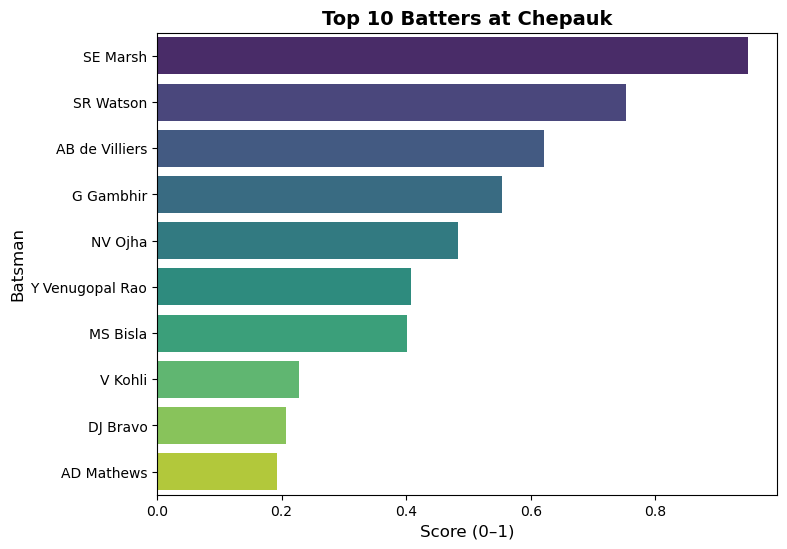

In [35]:
plt.figure(figsize=(8,6))
sns.barplot(data=top_10, x='score', y='batsman', palette="viridis")
plt.title("Top 10 Batters at Chepauk", fontsize=14, weight="bold")
plt.xlabel("Score (0–1)", fontsize=12)
plt.ylabel("Batsman", fontsize=12)

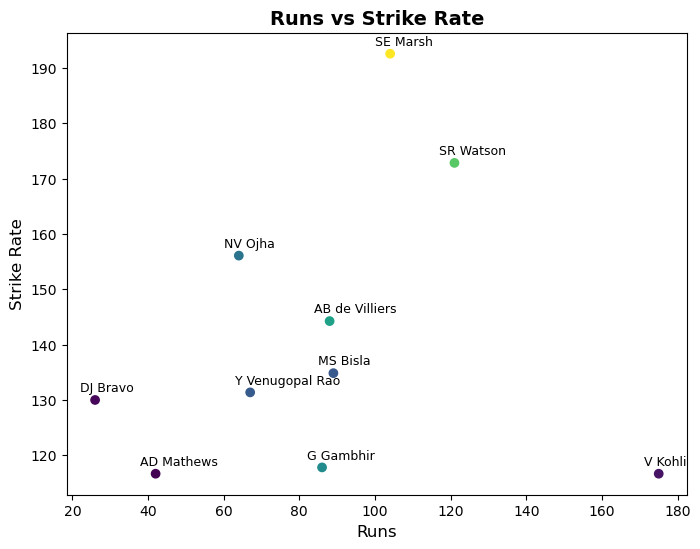

In [37]:
plt.figure(figsize=(8,6))

scatter = plt.scatter(
    top_10["runs"], top_10["SR"],
    c=top_10["score"], cmap="viridis"
)

plt.title("Runs vs Strike Rate", fontsize=14, weight="bold")
plt.xlabel("Runs", fontsize=12)
plt.ylabel("Strike Rate", fontsize=12)


for i, (x, y) in enumerate(zip(top_10["runs"], top_10["SR"])):
    plt.text(
        x-4, y+1.5,  # shift a bit to the right
        top_10["batsman"][i], 
        fontsize=9, weight="normal"
    )


# Key Insights

**Explosive Batsmen**: SE Marsh and SR Watson stand out with high runs and strong strike rates, making them the most impactful middle-over batters at Chepauk.

**Consistent Anchors**: NV Ojha, AB de Villiers provide steady run-scoring but at slightly lower strike rates, useful for building partnerships.
Gautam Gambhir and MS Bisla contribute useful runs but with relatively lower strike rates, suggesting more anchor-style batting.

**Less Impact Batsmen**: Bravo, Mathews, and Kohli either score fewer runs or at lower strike rates, thereby not having much of an impact at Chepauk.

**Final Takeaway**: Marsh and Watson are the go-to explosive batters, De Villiers/Ojha provide balance, while Gambhir and others play safer, anchor-like roles.